In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import get_scheduler
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tokenizers import Tokenizer, models, trainers
from transformers import PreTrainedTokenizerFast

C:\Users\Anh Nguyet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = "1000data.csv"
df = pd.read_csv(file_path)

In [3]:
df.columns = ["label", "query", "document"]
print(df)

      label                                              query  \
0         0  Bộ môn tiếng Anh tại Đại học Xây dựng Hà Nội c...   
1         1  Sinh viên có thể sử dụng thành thạo cả hai ngo...   
2         1  Hình thức tuyển sinh của chương trình đại học ...   
3         0    Sinh viên được phép làm những gì trên máy tính?   
4         1             các ngành nào có thể cấp bằng cử nhân?   
...     ...                                                ...   
1027      0  Sinh viên ngành này được trang bị những kiến t...   
1028      0  Viện KHCN CTT được thành lập theo quyết định nào?   
1029      1  Trường Đại học Xây dựng Hà Nội có tiền thân là gì   
1030      0  Trường Đại học Xây dựng Hà Nội đã nhận huân ch...   
1031      0  Viện công nghệ cao Việt Nhật tham gia đấu thầu...   

                                               document  
0     Quy mô tuyển sinh: 200 sinh viên/năm học ngành...  
1     sinh viên có thể sử dụng thành thạo cả 2 ngoại...  
2                       hình thức

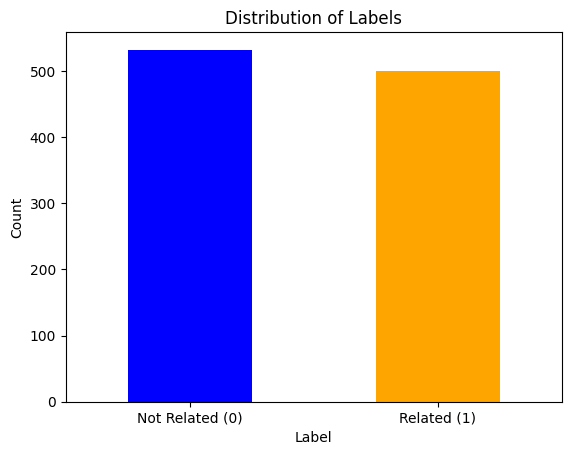

In [4]:
label_counts = df['label'].value_counts()
label_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not Related (0)', 'Related (1)'], rotation=0)
plt.show()

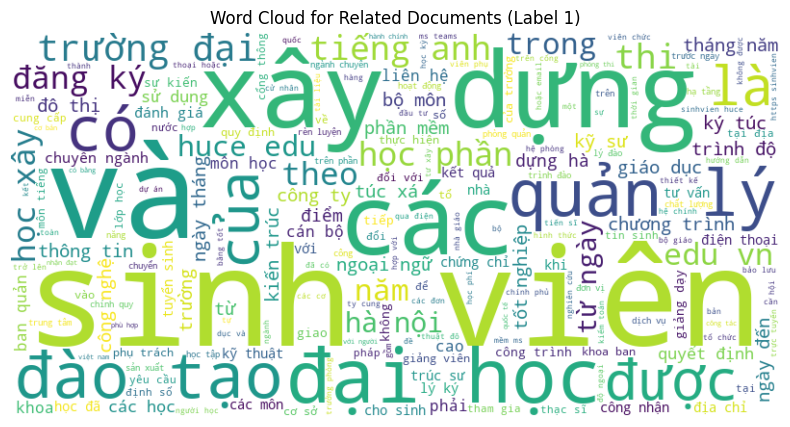

In [5]:
text_related = ' '.join(df[df['label'] == 1]['document'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_related)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Related Documents (Label 1)')
plt.show()

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = AutoModelForSequenceClassification.from_pretrained(
    "vinai/phobert-base", num_labels=2
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
class RelevanceDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        query = self.dataframe.iloc[index]["query"]
        document = self.dataframe.iloc[index]["document"]
        label = int(self.dataframe.iloc[index]["label"])

        encoding = self.tokenizer(
            query,
            document,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )

        inputs = {key: value.squeeze(0) for key, value in encoding.items()}
        inputs["labels"] = torch.tensor(label, dtype=torch.long)

        return inputs

In [9]:
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 2e-5

In [10]:
train_dataset = RelevanceDataset(train_df, tokenizer, MAX_LEN)
test_dataset = RelevanceDataset(test_df, tokenizer, MAX_LEN)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [12]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
num_training_steps = EPOCHS * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

C:\Users\Anh Nguyet\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [14]:
loss_values = []
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        batch = {key: value.to(device) for key, value in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_loss) 
    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {avg_loss}")

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 1/5, Loss: 0.5319006394308347


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 2/5, Loss: 0.09817109421755259


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 3/5, Loss: 0.045529664834388174


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 4/5, Loss: 0.0157119685318321


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Epoch 5/5, Loss: 0.015510476677893447


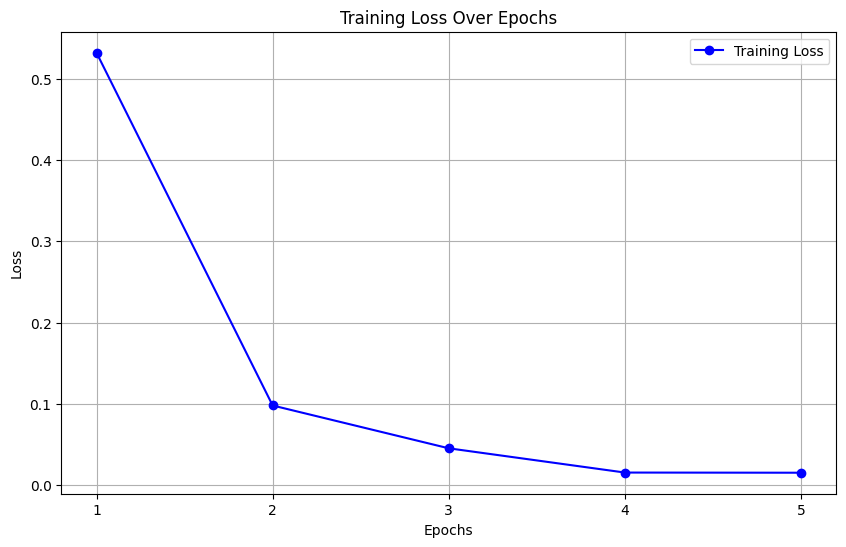

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), loss_values, marker='o', color='b', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, EPOCHS + 1)) 
plt.legend()
plt.grid()
plt.show()

In [16]:
# Evaluation
model.eval()
correct_predictions = 0

for batch in test_dataloader:
    batch = {key: value.to(device) for key, value in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    correct_predictions += (predictions == batch["labels"]).sum().item()

accuracy = correct_predictions / len(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Test Accuracy: 99.52%


In [17]:
model.save_pretrained("finetune_model")
tokenizer.save_pretrained("finetune_model")

('finetune_model\\tokenizer_config.json',
 'finetune_model\\special_tokens_map.json',
 'finetune_model\\vocab.txt',
 'finetune_model\\bpe.codes',
 'finetune_model\\added_tokens.json')

In [6]:
model = AutoModelForSequenceClassification.from_pretrained("finetune_model")
tokenizer = AutoTokenizer.from_pretrained("finetune_model")
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [7]:
def test_model_on_new_data(query, document, tokenizer, model, max_len=128):
    encoding = tokenizer(
        query,
        document,
        truncation=True,
        padding="max_length",
        max_length=max_len,
        return_tensors="pt",
    )

    inputs = {key: value.to(device) for key, value in encoding.items()}
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probabilities, dim=-1).item()

    if predicted_class == 1:
        print("1")
    else:
        print("0")

    print(
        f"Probabilities: Related = {probabilities[0][1]:.4f}, Not Related = {probabilities[0][0]:.4f}"
    )

In [8]:
#data nhiễu
query = "trường xây dựng có diện tích là bao nhiêu?"
document = "tại hà nội trường có tổng diện tích hơn 3.9ha trong đó có các khu giảng đường: nhà h1 6 tầng nhà h2 4 tầng nhà h3 7 tầng 2 tầng hầm nhà thư viện 4 tầng và nhà thí nghiệm 10 tầng trung tâm thể thao 1403 m2 hội trường g3 900 chỗ khu làm việc nhà a1 6 tầng nhà a2 2 tầng và ký túc xá sinh viên 801222 m2 1000 giường."

test_model_on_new_data(query, document, tokenizer, model)

1
Probabilities: Related = 0.9883, Not Related = 0.0117


In [65]:
import os
import pickle
from nltk.tokenize import word_tokenize
import nltk

def load_documents(folder_path):
    """Tải tài liệu từ thư mục."""
    documents = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                documents.append(file.read())
                filenames.append(filename)
    return documents, filenames

def create_index(documents, vocab):
    """Tạo chỉ mục cho các tài liệu dựa trên từ vựng."""
    index = {word: {} for word in vocab}
    for doc_id, text in enumerate(documents):
        text = text.lower()  # Chuyển đổi văn bản thành chữ thường
        for word in vocab:
            if word in text:
                index[word][doc_id] = text.count(word)  # Đếm số lần xuất hiện của từ
    return index

def save_index(index, filename='index.pkl'):
    """Lưu chỉ mục vào file."""
    with open(filename, 'wb') as f:
        pickle.dump(index, f)

def load_index(filename='index.pkl'):
    """Tải chỉ mục từ file."""
    with open(filename, 'rb') as f:
        return pickle.load(f)

def display_index(index):
    """Hiển thị chỉ mục."""
    for word, docs in index.items():
        print(f"{word}: {docs}")

def index_documents(folder_path, vocab):
    """Tạo và lưu chỉ mục từ tài liệu trong thư mục."""
    documents, _ = load_documents(folder_path)
    index = create_index(documents, vocab)
    save_index(index)
    print("Đã tạo và lưu chỉ mục mới.")
    return index  # Trả về chỉ mục để có thể hiển thị

# Đường dẫn đến thư mục chứa tài liệu và tệp từ vựng
folder_path = 'data'
vocab_file_path = 'vocab_ngram.txt'

# Tải từ vựng
with open(vocab_file_path, 'r', encoding='utf-8') as vocab_file:
    vocab = [line.strip() for line in vocab_file.readlines()]

# Tạo chỉ mục
index = index_documents(folder_path, vocab)

# Hiển thị chỉ mục
display_index(index)

Đã tạo và lưu chỉ mục mới.
lập trình viên: {65: 1, 66: 2, 67: 1, 87: 1}
định mức: {0: 1, 16: 1, 69: 2, 95: 2, 114: 1, 116: 1, 117: 1, 119: 1, 158: 2, 160: 2}
đo: {0: 1, 5: 3, 7: 1, 10: 5, 16: 3, 17: 1, 32: 1, 34: 3, 37: 2, 38: 8, 43: 2, 45: 3, 50: 1, 54: 3, 57: 6, 58: 11, 70: 1, 74: 2, 75: 1, 77: 1, 81: 1, 84: 2, 86: 2, 88: 2, 94: 1, 96: 1, 102: 2, 105: 2, 106: 1, 116: 1, 117: 1, 119: 1, 123: 9, 132: 3, 139: 1, 141: 10, 152: 3, 155: 1, 156: 1, 158: 1, 163: 2}
cấp phát: {95: 1, 99: 1, 103: 2, 104: 1, 108: 1, 115: 1, 116: 1, 117: 1, 119: 1, 123: 1}
chữ số: {99: 1, 116: 3, 117: 3, 118: 4, 119: 3}
bản thân: {21: 1, 22: 1, 23: 1, 78: 1, 79: 2, 89: 1, 95: 1, 116: 1, 117: 1, 118: 1, 119: 1, 123: 3, 144: 1}
hút: {0: 4, 48: 1, 70: 1, 79: 1, 97: 2, 98: 2, 116: 3, 117: 3, 118: 3, 119: 3, 123: 4, 132: 1, 139: 4, 143: 2, 158: 1}
khiêu dâm: {98: 1}
liên doanh: {54: 1, 88: 2, 92: 1, 93: 1, 153: 1, 157: 1, 160: 1}
tham ô: {123: 1}
dịch: {6: 1, 16: 7, 32: 1, 33: 1, 38: 1, 42: 1, 45: 1, 48: 1, 53: 1, 55

In [9]:
import os
import requests
from underthesea import word_tokenize
import nltk
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pickle
import math

nltk.download('punkt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("finetune_model").to(device)
tokenizer = AutoTokenizer.from_pretrained("finetune_model")

def load_documents(folder_path):
    """Tải tài liệu từ thư mục."""
    documents = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                documents.append(file.read())
                filenames.append(filename)
    return documents, filenames

def load_index(filename='index.pkl'):
    """Tải chỉ mục từ file."""
    with open(filename, 'rb') as f:
        return pickle.load(f)

def bm25_search(query, index, documents, vocab, k1=1.5, b=0.75):
    tokenized_query = word_tokenize(query.lower())
    scores = {}
    
    doc_lengths = [len(doc.split()) for doc in documents]
    avg_doc_length = sum(doc_lengths) / len(doc_lengths)

    for word in tokenized_query:
        if word in vocab and word in index: 
            for doc_id, freq in index[word].items():
                doc_length = doc_lengths[doc_id]
                
                # Tính IDF
                idf = 1 + math.log((len(documents) - len(index[word]) + 0.5) / (len(index[word]) + 0.5)) if len(index[word]) > 0 else 0
                
                # Tính TF
                tf = freq * (k1 + 1) / (freq + k1 * (1 - b + b * (doc_length / avg_doc_length)))  
                
                # Tính điểm cho tài liệu
                score = idf * tf
                
                if doc_id not in scores:
                    scores[doc_id] = 0
                scores[doc_id] += score

    return scores

def test_model_on_new_data(query, document, filename, tokenizer, model, max_len=128):
    """Dự đoán nhãn cho tài liệu mới."""
    encoding = tokenizer(
        query,
        document,
        truncation=True,
        padding="max_length",
        max_length=max_len,
        return_tensors="pt",
    )

    inputs = {key: value.to(device) for key, value in encoding.items()}
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probabilities, dim=-1).item()

    print(f"Nhãn cho văn bản: {filename} {predicted_class}")
    print(f"Xác suất: Tương đồng = {probabilities[0][1]:.4f}, Không tương đồng = {probabilities[0][0]:.4f}")
    
    return predicted_class, probabilities[0][1].item()

def call_gpt_api(prompt):
    """Gọi API GPT để nhận phản hồi."""
    api_key = 'sk-gA2KXQpdq3jE7n9APG5XBNsDufTC7O1cC6TkDFu5NwT3BlbkFJnnjHdF8FrxtwnhX_WPZICvtAnA2c5HyEGmqpE_L4sA'
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    data = {
        "model": "gpt-4o-mini",
        "messages": [{"role": "user", "content": prompt}],
        "max_tokens": 500 
    }
    
    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=data)
    
    if response.status_code == 200:
        return response.json()["choices"][0]["message"]["content"]
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None

def main():
    folder_path = 'data' 
    documents, filenames = load_documents(folder_path)

    # Tải chỉ mục
    index_file = 'index.pkl'
    vocab_file_path = 'vocab_ngram.txt'
    vocab = []

    if os.path.exists(index_file):
        index = load_index(index_file)
        print("Đã tải chỉ mục từ file.")
    else:
        print("Không tìm thấy chỉ mục. Vui lòng tạo chỉ mục trước.")
        return
        
    with open(vocab_file_path, 'r', encoding='utf-8') as vocab_file:
        vocab = [line.strip() for line in vocab_file.readlines()]

    query = input("Nhập query: ")
    scores = bm25_search(query, index, documents, vocab)

    # Lấy 3 văn bản có điểm cao nhất
    top_n = 3
    top_indices = sorted(scores.keys(), key=lambda i: scores[i], reverse=True)[:top_n]

    print("\n3 văn bản có điểm tương đồng cao nhất với:", query)
    
    if not top_indices:
        print("Không tìm thấy tài liệu nào phù hợp.")
        return

    all_best_documents = []
    for doc_id in top_indices:
        predicted_class, prob = test_model_on_new_data(query, documents[doc_id], filenames[doc_id], tokenizer, model)
        
        if predicted_class == 1:  # Chỉ lấy văn bản có nhãn 1
            all_best_documents.append(documents[doc_id])
        else:
            print(f"Tài liệu {filenames[doc_id]} có nhãn 0 và sẽ không được gửi đến GPT.")

    if all_best_documents:
        prompt = f"Dựa trên các văn bản: {', '.join(all_best_documents)}, hãy trả lời câu hỏi {query} như assistant của trường đại học xây dựng. Nếu là lời chào thì hãy trả lời đáp lại, nếu không có câu trả lời hãy đưa ra các thông tin liên hệ liên quan từ các file."
        response = call_gpt_api(prompt)
        if response:
            print("Câu trả lời:", response)
    else:
        print("Không tìm thấy văn bản nào có nhãn 1.")

if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to C:\Users\Anh
[nltk_data]     Nguyet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Đã tải chỉ mục từ file.


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.



3 văn bản có điểm tương đồng cao nhất với: các loại học bổng đang có


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Nhãn cho văn bản: hocbong.txt 1
Xác suất: Tương đồng = 0.9920, Không tương đồng = 0.0080


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Nhãn cho văn bản: Viện Địa kỹ thuật & Công trình_cleaned.txt 1
Xác suất: Tương đồng = 0.9838, Không tương đồng = 0.0162
Nhãn cho văn bản: Ngành kinh tế xây dựng _ Chuyên ngành kinh tế và quản lý đô thị_cleaned.txt 1
Xác suất: Tương đồng = 0.9836, Không tương đồng = 0.0164
Câu trả lời: Chào bạn! Dưới đây là danh sách các loại học bổng đang có tại Trường Đại học Xây dựng:

1. **Học bổng Khuyến khích Học tập**: Dành cho sinh viên hệ chính quy có kết quả học tập và rèn luyện đạt loại khá trở lên. Quỹ học bổng này được cấp từ 8% nguồn thu học phí hệ đào tạo chính quy.

2. **Các học bổng khác từ các đơn vị trong và ngoài trường**:
   - Học bổng Đỗ Quốc Sam
   - Học bổng CSC
   - Học bổng Merali
   - Học bổng Kumho Asiana
   - Học bổng quốc tế

3. **Chương trình Học bổng Quốc tế**: Các chương trình học bổng của các cơ sở đào tạo nước ngoài, như:
   - Học bổng Chevening (Chính phủ Anh)
   - Học bổng DAAD (Đức)
   - Học bổng của các chính phủ Australia, Canada, New Zealand, Nhật Bản, Hàn Quốc, 